# Data Engineering and Unsupervised Text Clustering with K-Means

In the present notebook we will use the k-means algorithm, an unsupervised clustering algorithm, to cluster the topics into different groups.

Before the model can be applied we would like to do pre processing on the data given so that it is fit for the model to be applied.

We perform the following steps on the data: <br>
1.Lowering the case <br>
2.Removing the punctuation <br>
3.Removing the stopwords <br>
4.Removing frequent words <br>
5.Removing rare words <br>
6.Stemming <br>
7.Lemmatization <br>

The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve <br> this objective, K-means looks for a fixed defined number (k) of centroids in a dataset. A centroid refers to a <br> cluster, which is a collection of data points aggregated together because of certain similarities with each <br> other. The ‘means’ in the K-means refers to the averaging of the data; that is, finding the centroid. And the <br> algorithm is said to be unsupervised because we have no prior knowledge with regards to the groups or classes of our <br> dataset, that is, we will find the underlying groups in our dataset. <br>

Below we can visualize the algorithm. The green centroids matches the closest datapoints to each one and form <br> clusters, then each centroid moves to the center of each respective group and matches again the closest datapoint to <br> each other.

In [2]:
import pandas as pd
import warnings
import csv
import re
import nltk
import spacy
import string
import os
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize
from sklearn import cluster
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
warnings.filterwarnings('ignore')

In [3]:
cwd = os.getcwd()
with open(cwd+'/csv/topics.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(",") for line in stripped if line)
    with open(cwd+'input.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('title'))
        writer.writerows(lines)

In [4]:
df = pd.read_csv(cwd+'input.csv',sep='delimiter', header=None)
df.head()

,0
0,"t,i,t,l,e"
1,"""""""Seals for FTB#2 Wing with Additive Manufact..."
2,'First of a Kind' solutions for sustainable tr...
3,10. Innovative Enterprise Week 2018 - Austria
4,12. Innovative Enterprise Week 2019


In [5]:
new_header = df.iloc[0]
df = df[1:] 
df.columns = new_header 

In [6]:
df.rename(columns={'t,i,t,l,e':'title'}, inplace=True)
df


,title
1,"""""""Seals for FTB#2 Wing with Additive Manufact..."
2,'First of a Kind' solutions for sustainable tr...
3,10. Innovative Enterprise Week 2018 - Austria
4,12. Innovative Enterprise Week 2019
5,13. 'Innovative Enterprise Week 2017'
...,...
3254,e-Infrastructure policy development and intern...
3255,e-Infrastructures for virtual research environ...
3256,eHealth interoperability
3257,peer learning of innovation agencies


In [7]:
df["title"] = df["title"].astype(str)

# Lowering the case

In [8]:
df["text_lower"] = df["title"].str.lower()
df.head()

,title,text_lower
1,"""""""Seals for FTB#2 Wing with Additive Manufact...","""""""seals for ftb#2 wing with additive manufact..."
2,'First of a Kind' solutions for sustainable tr...,'first of a kind' solutions for sustainable tr...
3,10. Innovative Enterprise Week 2018 - Austria,10. innovative enterprise week 2018 - austria
4,12. Innovative Enterprise Week 2019,12. innovative enterprise week 2019
5,13. 'Innovative Enterprise Week 2017',13. 'innovative enterprise week 2017'


# Removing the punctuation

In [9]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df["text_lower"].apply(lambda text: remove_punctuation(text))
df.head()

,title,text_lower,text_wo_punct
1,"""""""Seals for FTB#2 Wing with Additive Manufact...","""""""seals for ftb#2 wing with additive manufact...",seals for ftb2 wing with additive manufacturin...
2,'First of a Kind' solutions for sustainable tr...,'first of a kind' solutions for sustainable tr...,first of a kind solutions for sustainable tran...
3,10. Innovative Enterprise Week 2018 - Austria,10. innovative enterprise week 2018 - austria,10 innovative enterprise week 2018 austria
4,12. Innovative Enterprise Week 2019,12. innovative enterprise week 2019,12 innovative enterprise week 2019
5,13. 'Innovative Enterprise Week 2017',13. 'innovative enterprise week 2017',13 innovative enterprise week 2017


In [10]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

# Removing the stopwords

In [11]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df.head()

,title,text_lower,text_wo_punct,text_wo_stop
1,"""""""Seals for FTB#2 Wing with Additive Manufact...","""""""seals for ftb#2 wing with additive manufact...",seals for ftb2 wing with additive manufacturin...,seals ftb2 wing additive manufacturing technol...
2,'First of a Kind' solutions for sustainable tr...,'first of a kind' solutions for sustainable tr...,first of a kind solutions for sustainable tran...,first kind solutions sustainable transport mob...
3,10. Innovative Enterprise Week 2018 - Austria,10. innovative enterprise week 2018 - austria,10 innovative enterprise week 2018 austria,10 innovative enterprise week 2018 austria
4,12. Innovative Enterprise Week 2019,12. innovative enterprise week 2019,12 innovative enterprise week 2019,12 innovative enterprise week 2019
5,13. 'Innovative Enterprise Week 2017',13. 'innovative enterprise week 2017',13 innovative enterprise week 2017,13 innovative enterprise week 2017


In [12]:
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('research', 254),
 ('development', 225),
 ('innovation', 219),
 ('technologies', 202),
 ('energy', 190),
 ('support', 178),
 ('innovative', 169),
 ('european', 162),
 ('system', 149),
 ('systems', 137)]

# Removing frequent words

In [13]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text))
df.head()


,title,text_lower,text_wo_punct,text_wo_stop,text_wo_stopfreq
1,"""""""Seals for FTB#2 Wing with Additive Manufact...","""""""seals for ftb#2 wing with additive manufact...",seals for ftb2 wing with additive manufacturin...,seals ftb2 wing additive manufacturing technol...,seals ftb2 wing additive manufacturing
2,'First of a Kind' solutions for sustainable tr...,'first of a kind' solutions for sustainable tr...,first of a kind solutions for sustainable tran...,first kind solutions sustainable transport mob...,first kind solutions sustainable transport mob...
3,10. Innovative Enterprise Week 2018 - Austria,10. innovative enterprise week 2018 - austria,10 innovative enterprise week 2018 austria,10 innovative enterprise week 2018 austria,10 enterprise week 2018 austria
4,12. Innovative Enterprise Week 2019,12. innovative enterprise week 2019,12 innovative enterprise week 2019,12 innovative enterprise week 2019,12 enterprise week 2019
5,13. 'Innovative Enterprise Week 2017',13. 'innovative enterprise week 2017',13 innovative enterprise week 2017,13 innovative enterprise week 2017,13 enterprise week 2017


# Removing rare words

In [14]:
# Drop the two columns which are no more needed 
df.drop(["text_wo_punct", "text_wo_stop"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()


,title,text_lower,text_wo_stopfreq,text_wo_stopfreqrare
1,"""""""Seals for FTB#2 Wing with Additive Manufact...","""""""seals for ftb#2 wing with additive manufact...",seals ftb2 wing additive manufacturing,seals ftb2 wing additive manufacturing
2,'First of a Kind' solutions for sustainable tr...,'first of a kind' solutions for sustainable tr...,first kind solutions sustainable transport mob...,first kind solutions sustainable transport mob...
3,10. Innovative Enterprise Week 2018 - Austria,10. innovative enterprise week 2018 - austria,10 enterprise week 2018 austria,10 enterprise week 2018 austria
4,12. Innovative Enterprise Week 2019,12. innovative enterprise week 2019,12 enterprise week 2019,12 enterprise week 2019
5,13. 'Innovative Enterprise Week 2017',13. 'innovative enterprise week 2017',13 enterprise week 2017,13 enterprise week 2017


# Stemming

It is also known as the text standardization step where the words are stemmed or diminished to their root/base form.  For example, words like ‘programmer’, ‘programming, ‘program’ will be stemmed to ‘program’.

But the disadvantage of stemming is that it stems the words such that its root form loses the meaning or it is not diminished to a proper English word. We will see this in the steps done below.

In [15]:
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["text_stemmed"] = df["text_wo_stopfreqrare"].apply(lambda text: stem_words(text))
df.head()


,title,text_lower,text_wo_stopfreq,text_wo_stopfreqrare,text_stemmed
1,"""""""Seals for FTB#2 Wing with Additive Manufact...","""""""seals for ftb#2 wing with additive manufact...",seals ftb2 wing additive manufacturing,seals ftb2 wing additive manufacturing,seal ftb2 wing addit manufactur
2,'First of a Kind' solutions for sustainable tr...,'first of a kind' solutions for sustainable tr...,first kind solutions sustainable transport mob...,first kind solutions sustainable transport mob...,first kind solut sustain transport mobil eu in...
3,10. Innovative Enterprise Week 2018 - Austria,10. innovative enterprise week 2018 - austria,10 enterprise week 2018 austria,10 enterprise week 2018 austria,10 enterpris week 2018 austria
4,12. Innovative Enterprise Week 2019,12. innovative enterprise week 2019,12 enterprise week 2019,12 enterprise week 2019,12 enterpris week 2019
5,13. 'Innovative Enterprise Week 2017',13. 'innovative enterprise week 2017',13 enterprise week 2017,13 enterprise week 2017,13 enterpris week 2017


# Lemmatization

It stems the word but makes sure that it does not lose its meaning.  Lemmatization has a pre-defined dictionary that stores the context of words and checks the word in the dictionary while diminishing.

The difference between Stemming and Lemmatization can be understood with the example provided below.

In [16]:
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["text_lemmatized"] = df["text_wo_stopfreqrare"].apply(lambda text: lemmatize_words(text))
df.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/manika/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,title,text_lower,text_wo_stopfreq,text_wo_stopfreqrare,text_stemmed,text_lemmatized
1,"""""""Seals for FTB#2 Wing with Additive Manufact...","""""""seals for ftb#2 wing with additive manufact...",seals ftb2 wing additive manufacturing,seals ftb2 wing additive manufacturing,seal ftb2 wing addit manufactur,seal ftb2 wing additive manufacturing
2,'First of a Kind' solutions for sustainable tr...,'first of a kind' solutions for sustainable tr...,first kind solutions sustainable transport mob...,first kind solutions sustainable transport mob...,first kind solut sustain transport mobil eu in...,first kind solution sustainable transport mobi...
3,10. Innovative Enterprise Week 2018 - Austria,10. innovative enterprise week 2018 - austria,10 enterprise week 2018 austria,10 enterprise week 2018 austria,10 enterpris week 2018 austria,10 enterprise week 2018 austria
4,12. Innovative Enterprise Week 2019,12. innovative enterprise week 2019,12 enterprise week 2019,12 enterprise week 2019,12 enterpris week 2019,12 enterprise week 2019
5,13. 'Innovative Enterprise Week 2017',13. 'innovative enterprise week 2017',13 enterprise week 2017,13 enterprise week 2017,13 enterpris week 2017,13 enterprise week 2017


# Word Cloud before clustering

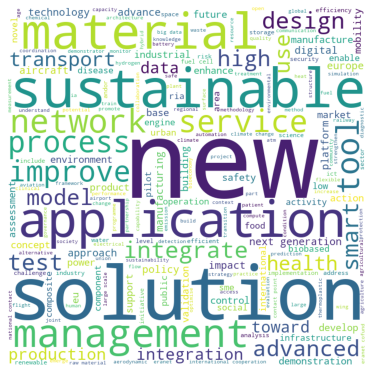

In [17]:
# if using a Jupyter notebook, include:
%matplotlib inline

all_words = '' 

#looping through all incidents and joining them to one text, to extract most common words
for arg in df["text_lemmatized"]: 

    tokens = arg.split()  
      
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [18]:
df


,title,text_lower,text_wo_stopfreq,text_wo_stopfreqrare,text_stemmed,text_lemmatized
1,"""""""Seals for FTB#2 Wing with Additive Manufact...","""""""seals for ftb#2 wing with additive manufact...",seals ftb2 wing additive manufacturing,seals ftb2 wing additive manufacturing,seal ftb2 wing addit manufactur,seal ftb2 wing additive manufacturing
2,'First of a Kind' solutions for sustainable tr...,'first of a kind' solutions for sustainable tr...,first kind solutions sustainable transport mob...,first kind solutions sustainable transport mob...,first kind solut sustain transport mobil eu in...,first kind solution sustainable transport mobi...
3,10. Innovative Enterprise Week 2018 - Austria,10. innovative enterprise week 2018 - austria,10 enterprise week 2018 austria,10 enterprise week 2018 austria,10 enterpris week 2018 austria,10 enterprise week 2018 austria
4,12. Innovative Enterprise Week 2019,12. innovative enterprise week 2019,12 enterprise week 2019,12 enterprise week 2019,12 enterpris week 2019,12 enterprise week 2019
5,13. 'Innovative Enterprise Week 2017',13. 'innovative enterprise week 2017',13 enterprise week 2017,13 enterprise week 2017,13 enterpris week 2017,13 enterprise week 2017
...,...,...,...,...,...,...
3254,e-Infrastructure policy development and intern...,e-infrastructure policy development and intern...,einfrastructure policy international cooperation,einfrastructure policy international cooperation,einfrastructur polici intern cooper,einfrastructure policy international cooperation
3255,e-Infrastructures for virtual research environ...,e-infrastructures for virtual research environ...,einfrastructures virtual environments vre,einfrastructures virtual environments,einfrastructur virtual environ,einfrastructures virtual environment
3256,eHealth interoperability,ehealth interoperability,ehealth interoperability,ehealth interoperability,ehealth interoper,ehealth interoperability
3257,peer learning of innovation agencies,peer learning of innovation agencies,peer learning agencies,peer learning agencies,peer learn agenc,peer learning agency


In [19]:
corpus = df['text_lemmatized'].tolist()

# Statistical Weighing of Words

Now we will apply the TF-IDF function, short for term frequency inverse document frequency, which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1.



In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

3258 rows


,0,1,2,3,4,5,6,7,8,9,...,3248,3249,3250,3251,3252,3253,3254,3255,3256,3257
ftb2,0.538054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
seal,0.538054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
additive,0.407024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wing,0.385290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
manufacturing,0.326922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# K-Means

Function that runs the K-Means algorithm max_k times and returns a dictionary of each k result

In [21]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

# Silhouette Score 

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [22]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [23]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Cluster Analysis

Now we can choose the best number of K and take a deeper look at each cluster. Looking at the plots above, we have some clues that when K = 5 is when the clusters are best defined. So first we will use a simple histogram to look at the most dominant words in each cluster:

In [24]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

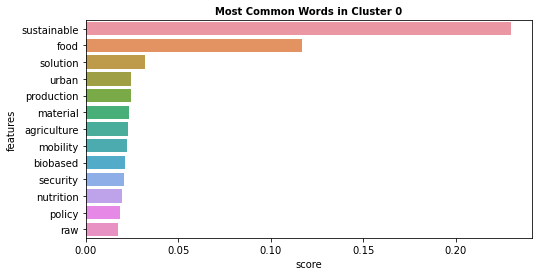

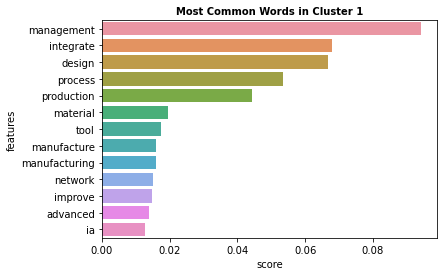

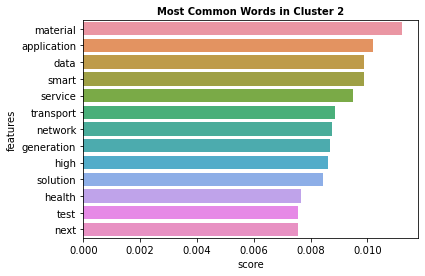

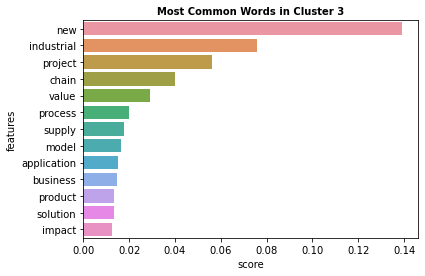

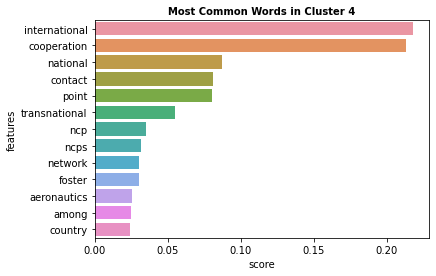

In [25]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

# Map of Words

Now that we can look at the graphs above and see the best scored words in each cluster, it's also interesting to make it prettier by making a map of words of each cluster.

In [26]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

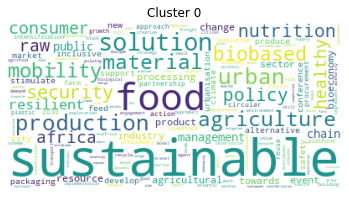

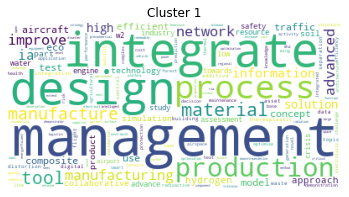

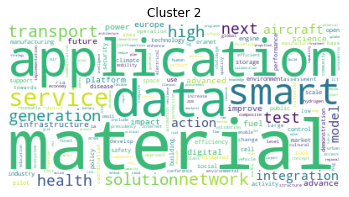

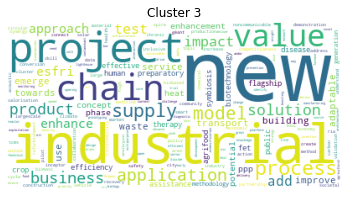

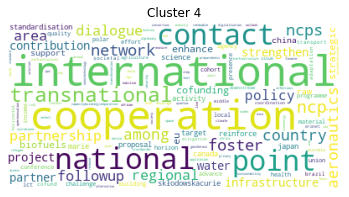

In [27]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [28]:
labels = kmeans.labels_ 
df['label'] = labels
df.head()

,title,text_lower,text_wo_stopfreq,text_wo_stopfreqrare,text_stemmed,text_lemmatized,label
1,"""""""Seals for FTB#2 Wing with Additive Manufact...","""""""seals for ftb#2 wing with additive manufact...",seals ftb2 wing additive manufacturing,seals ftb2 wing additive manufacturing,seal ftb2 wing addit manufactur,seal ftb2 wing additive manufacturing,2
2,'First of a Kind' solutions for sustainable tr...,'first of a kind' solutions for sustainable tr...,first kind solutions sustainable transport mob...,first kind solutions sustainable transport mob...,first kind solut sustain transport mobil eu in...,first kind solution sustainable transport mobi...,0
3,10. Innovative Enterprise Week 2018 - Austria,10. innovative enterprise week 2018 - austria,10 enterprise week 2018 austria,10 enterprise week 2018 austria,10 enterpris week 2018 austria,10 enterprise week 2018 austria,2
4,12. Innovative Enterprise Week 2019,12. innovative enterprise week 2019,12 enterprise week 2019,12 enterprise week 2019,12 enterpris week 2019,12 enterprise week 2019,2
5,13. 'Innovative Enterprise Week 2017',13. 'innovative enterprise week 2017',13 enterprise week 2017,13 enterprise week 2017,13 enterpris week 2017,13 enterprise week 2017,2
